In [1]:
import os
import urllib
import pandas as pd
import numpy as np
from numpy.random import uniform, binomial
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

import time

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

# To remove WARNINGS from saving the models without compiling them first
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#print(tf.__version__)
#print(tf.test.gpu_device_name())

## Parameters

In [2]:
names = ['wine', 'default_credit', 'compas', 'lsat']

art_Npoints = [1438+160, 27000+3000, 5554+618, 17432+4358]
art_Ntrain = [1438, 27000, 5554, 17432]

test_dims = [[11], [29, 30], [17, 18], [12]] # COMPAS has in total 19 features so the position of targets are 17 and 18
test_dims_rel = [-1, [-2, -1], [-2, -1], -1] # Target position in the sample

bnn_widths = [200, 200, 200, 200]
bnn_depths = [2, 2, 2, 2]

vae_widths = [300, 300, 300, 300] # [200, 200, 200, 200]
vae_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vae_latent_dims = [6, 8, 4, 4]

vaeac_widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
vaeac_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vaeac_latent_dims = [6, 8, 4, 4]
vaeac_under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
vaeac_under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

# For automatic explainer generation

regression_bools = [True, False, False, True] # If the target is continous
gauss_cat_vae_bools = [False, True, True, True] # If the features are continous and categorical (False = only cont.)
flat_vae_bools = [False, False, False, False]
flat_vaeac_bools = [False, True, False, False]

var_names = {}
var_names_flat = {}

var_names['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
var_names_flat['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

var_names['default_credit'] = ['Given credit', 'Gender', 'Education', 'Marital status', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']
var_names_flat['default_credit'] = ['Given credit', 'Gender M', 'Gender F', 'Education grad', 'Education under', 'Education HS', 'Education Other',
                 'Marital status M', 'Marital status S', 'Marital status Other', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']

var_names['compas'] = ["age_cat", "race", "sex", "c_charge_degree", 'is_recid', 'priors_count', 'time_served']
var_names_flat['compas'] = ['25 - 45', 'Greater than 45', 'Less than 25', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'Female', 'Male', 'Felony', 'misdemeanour', 'not_recid', 'is_recid', 'priors_count', 'time_served']

var_names['lsat'] = ['LSAT', 'UGPA', 'race', 'sex']
var_names_flat['lsat'] = ['LSAT', 'UGPA', 'amerind', 'mexican', 'other', 'black', 'asian', 'puerto', 'hisp', 'white', 'female', 'male']



In [3]:
dname = 'compas'
d_idx = names.index(dname)
print(dname)
print(d_idx)

compas
2


## Required functions

In [4]:
def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    """
    Converts a feature vector with continous values into a vector with continous and discrete values for those 
    which come from a categorical class.
    """
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x

In [5]:
from __future__ import division
import datetime
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import seed


"""
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        try:
            response = urllib2.urlopen(addr)
        except:
            response = urllib3.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "w")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."
"""

def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable

    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        print(X_dims.shape, x_means.shape)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims

def join_compas_targets(x_train, x_test, y_train, y_test, X_dims):
    # output from get method is onehot so we need to flatten and append 2
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    input_dim_vec = np.append(input_dim_vec, 2)
    enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
    enc.fit(y_train.reshape(-1, 1))

    vals_train = np.array(enc.transform(y_train.reshape(-1, 1)).todense()).astype(np.float32)
    vals_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()).astype(np.float32)

    x_train = np.concatenate([x_train, vals_train], axis=1)
    x_test = np.concatenate([x_test, vals_test], axis=1)
    return x_train, x_test, input_dim_vec

def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

#"""
def input_dim_vec_to_X_dims(input_dim_vec):
    # This is for our cat_Gauss VAE model
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)
#"""

In [6]:
#from src.UCI_loader import load_UCI, unnormalise_cat_vars
#from src.compas_loader import get_my_COMPAS, X_dims_to_input_dim_vec, join_compas_targets
#from src.LSAT_loader import get_my_LSAT, join_LSAT_targets
#from src.gauss_cat import gauss_cat_to_flat


if dname == 'wine':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=True, save_dir='../../data/')
    xy_train, xy_test, xy_means, xy_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../../data/')
    print(x_train.shape)
    print(xy_train.shape)
    
elif dname == 'default_credit':
    # Note that this dataset is given without flattening
    xy_train, xy_test, xy_means, xy_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../../data/')
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
        load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=True, save_dir='../../data/')
    print('Credit', xy_train.shape, xy_test.shape)
    input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1]
    input_dim_vec_xy = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
    
    x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
    x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)
    y_train = unnormalise_cat_vars(y_train, y_means, y_stds, [2])
    y_test = unnormalise_cat_vars(y_test, y_means, y_stds, [2])
    
    xy_train = unnormalise_cat_vars(xy_train, xy_means, xy_stds, input_dim_vec_xy)
    xy_test = unnormalise_cat_vars(xy_test, xy_means, xy_stds, input_dim_vec_xy)
    
    xy_train = gauss_cat_to_flat(torch.Tensor(xy_train), input_dim_vec_xy)
    xy_test = gauss_cat_to_flat(torch.Tensor(xy_test), input_dim_vec_xy)
    print(input_dim_vec_xy)

elif dname == 'compas':
    x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')
    
    xy_train, xy_test, input_dim_vec_xy = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    print(dname)
    print(x_means.shape)
    xy_means = np.append(x_means, [0, 0])
    xy_stds = np.append(x_stds, [1, 1])
    print(input_dim_vec)
    print(input_dim_vec_xy)
    
elif dname == 'lsat':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, my_data_keys, input_dim_vec = \
    get_my_LSAT(save_dir='../../data/')
    xy_means = np.concatenate([x_means, y_means])
    xy_stds = np.concatenate([x_stds, y_stds])
    xy_train, xy_test, input_dim_vec_xy = join_LSAT_targets(x_train, x_test, y_train, y_test, input_dim_vec)
    print('LSAT', x_train.shape, x_test.shape)
    print(input_dim_vec_xy)

compas
(17,)
[3 6 2 2 2 1 1]
[3 6 2 2 2 1 1 2]


## Recgonition Encoder

In [7]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_recognition_encoder(width, depth, latent_dim, input_dim_vec):
    # Tensorflow network as one big Russian doll
    nb_inputs = sum(input_dim_vec)
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        # Skip connection 
        x = x + input

        input = x

    # Final layers
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    recognition_encoder = keras.Model(inputs=inputs, outputs=outputs, name="recognition_encoder_model")
    return recognition_encoder
#recognition_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(recognition_encoder, "recognition.png", show_shapes=True)




## Prior Encoder

In [8]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""
def create_prior_encoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = sum(input_dim_vec)*2
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    prior_encoder = keras.Model(inputs=inputs, outputs=outputs, name="prior_encoder_model")
    return prior_encoder
#prior_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(prior_encoder, "prior.png", show_shapes=True)


## Decoder

In [9]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""
def create_decoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = latent_dim
    inputs = keras.Input(shape=(nb_inputs,))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)
        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(sum(input_dim_vec), use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    decoder = keras.Model(inputs=inputs, outputs=outputs, name="decoder_model")
    return decoder

#decoder.summary()

#keras.utils.plot_model(model, "decoder_model.png")
#keras.utils.plot_model(decoder, "generator.png", show_shapes=True)


## Categorical VAEAC

In [10]:
class VAEAC_gauss_cat(tf.keras.Model):
    def __init__(self, width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model):
        super(VAEAC_gauss_cat, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim_vec = input_dim_vec
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, input_dim_vec)
        self.prior_encoder = create_prior_encoder(width, depth, latent_dim, input_dim_vec)
        self.decoder = create_decoder(width, depth, latent_dim, input_dim_vec)
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4
        self.vlb_scale = 1 / len(self.input_dim_vec)
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model
        self.lr = lr
        

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py
    def prior_regularizer(self, prior):

        mu = tf.reshape(prior.mean(), (self.batch_size, -1))
        sigma = tf.reshape(prior.scale, (self.batch_size, -1))

        mu_regularizer = -tf.reduce_sum(tf.square(mu), -1) / (2 * self.sigma_mu ** 2)
        sigma_regularizer = tf.reduce_sum((tf.math.log(sigma) - sigma), -1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def apply_mask(self, x, mask):
        return x * mask

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        cum_dims = 0
        reshape_dim = self.batch_size
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(tf.expand_dims(-(x[:, cum_dims] - y[:, cum_dims])**2, 1))
                
                cum_dims += 1

            elif dims > 1:
                # if x.shape[1] == y.shape[1]:
                #    raise Exception('Input and target seem to be in flat format. Need integer cat targets.'

                cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits = True)
                cat_cross_entropy = -cce(tf.cast(y[:, cum_dims:cum_dims + dims], dtype=tf.int64), x[:, cum_dims:cum_dims + dims])
                
                log_prob_vec.append(tf.expand_dims(cat_cross_entropy, 1))
                cum_dims += dims

            else:
                raise ValueError('Error, invalid dimension value')

        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, len(self.input_dim_vec)])
        log_prob_vec = tf.reduce_sum(log_prob_vec, axis= -1) # Do I want this? 
                                                                 # Yes vlb in original code does this when return
        return log_prob_vec

    """
    def generate_samples_params(self, inputs, masks, sample=1):

        #Takes a model and 

        # (batch_size, width, height, channels)
        observed_inputs = self.make_observed_inputs(inputs, masks)
        # (batch_size, width, height, 2*channels)
        observed_inputs_with_masks = tf.concat([observed_inputs, masks], axis=-1)

        prior_params = self.prior_net(observed_inputs_with_masks)

        prior_distribution = tfd.Normal(
          loc=prior_params[..., :256],
          scale=tf.clip_by_value(
            tf.nn.softplus(prior_params[..., 256:]),
            1e-3,
            tf.float32.max),
          name="priors")

        samples_params = []
        for i in range(sample):
          latent = prior_distribution.sample()
          sample_params = self.generative_net(latent)
          samples_params.append(sample_params)
        return tf.stack(samples_params, axis=1)
    """
    
    # TODO Implement correctly
    """
    def generate_sample(self, sample=1):
        if(self.proposal_distribution == None):
            raise Exception('Network has no proposal distribution. Train it first')
        else:
            latent = proposal_distribution.sample()

            generative_params = self.decoder(latent)
        
            return generative_params
    """

def eval(model, x_batch, x_flat, x_masked, mask):

    x_flat = tf.convert_to_tensor(x_flat)

    prior_params = model.prior_encoder(x_masked)
    #prior_params = model.prior_encoder(x_masked, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False)

    proposal_params = model.recognition_encoder(x_flat)
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    z_sample = proposal_distribution.loc

    rec_params = model.decoder(z_sample)
    #rec_params = model.decoder(z_sample, training = True)
    #rec_params = model.decoder(z_sample, training = False)
    
    regularizer = model.prior_regularizer(prior_distribution)

    rec_loss = model.reconstruction_loss(rec_params, x_flat)

    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    return vlb, kl_divergence, rec_loss, regularizer

def compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask):
    
    prior_params = model.prior_encoder(x_masked) 
    proposal_params = model.recognition_encoder(x_flat)
    #prior_params = model.prior_encoder(x_masked, training = True) 
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False) 
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    regularizer = model.prior_regularizer(prior_distribution)

    latent = proposal_distribution.sample()

    generative_params = model.decoder(latent)
    #generative_params = model.decoder(latent, training = True)
    #generative_params = model.decoder(latent, training = False)
    
    rec_loss = model.reconstruction_loss(generative_params, x_flat)
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss - regularizer) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss, regularizer

@tf.function # Converts all numpy arrays to tensors
def train_step_VAEAC(model, x_batch, x_flat, x_masked, mask):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss, regularizer = compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, vlb, kl_divergence, rec_loss, regularizer



In [11]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop = None, flatten=False):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        
        # Shuffle the training data and sort it into batches every epoch
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        tic = time.time()

        ## Training
        nb_samples = 0
        
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
                
            mask = masker(x_batch) #tensor with floats
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
                mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
                mask_flat = mask

            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            loss, vlb, kl_divergence, rec_loss, regularizer = train_step_VAEAC(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch_" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size

            mask = masker(x_batch) #tensor with floats
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
                mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
                mask_flat = mask
            
            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            vlb, kl_divergence, rec_loss, regularizer = eval(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples
    
        
        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                
                #open text file
                text_file = open(str(dname) + "_best_epoch_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save(str(dname) + "_recog_encoder_lr_" + str(model.lr))
                model.prior_encoder.save(str(dname) + "_prior_encoder_lr_" + str(model.lr))
                model.decoder.save(str(dname) + "_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save(str(dname) + "_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save(str(dname) + "_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch
        

## under VAEAC

In [12]:
class under_VAEAC(tf.keras.Model):
    def __init__(self, base_VAE, width, depth, latent_dim, batch_size, lr, optimizer, save_model = True):
        super(under_VAEAC, self).__init__()
        
        self.base_VAEAC = base_VAE
        self.input_dim = self.base_VAEAC.latent_dim # 8 for default credit
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim # 6 for default credit
        self.lr = lr
        
        self.prior_encoder = tfd.Normal(loc=tf.zeros(latent_dim), scale=tf.ones(latent_dim))
        
        # self.input_dim is put in a list to make sum(input_dim_vec in recognition_encoder work)
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, [self.input_dim])
        self.decoder = create_decoder(width, depth, latent_dim, [self.input_dim])
        
        self.vlb_scale = 1 / self.input_dim
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        reshape_dim = self.batch_size
        for idx in range(self.input_dim):
            # Gaussian_case
            log_prob_vec.append(tf.expand_dims(-(x[:, idx] - y[:, idx])**2, 1))

        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, self.input_dim])
        log_prob_vec = tf.math.reduce_sum(log_prob_vec, axis= -1)
        
        return log_prob_vec
    
    def u_regenerate(self, u, grad=False):
        #self.set_mode_train(train=False)
        """
        if grad:
            raise Exception('Not yet implemented')
            #if not u.requires_grad:
            #    u.requires_grad = True
        else:
            u, = to_variable(var=(u,), volatile=True, cuda=self.cuda) 
        """
        
        # We should only do inference and not back_propagation with u
        
        z = self.decoder(u)
        out = self.base_VAEAC.decoder(z) # Tensor with size Npoints, sum(input_dim_vec)
        #if self.base_VAEAC.pred_sig:
        #    raise Exception('Not yet implemented')
            #return normal_parse_params(out, 1e-2)
        #else:
        return out
    
def compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC):
    """
    N.B. below comments are made for default credit tensors 
    """
    
    """
    x_flat = tf.convert_to_tensor(x_flat)

    proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_flat) # tensor with dim (16,)
    """
    
    # Essentially CLUEs normal_parse_params
    proposal_distribution_VAEAC = tfd.Normal(
      loc=proposal_params_VAEAC[..., :model.input_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAEAC[..., model.input_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")
    
    z_sample = proposal_distribution_VAEAC.sample() # tensor with dim (8,)
    
    proposal_params_VAE = model.recognition_encoder(z_sample) # tensor with dim (12,)

    proposal_distribution_VAE = tfd.Normal(
      loc=proposal_params_VAE[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAE[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    u_sample = proposal_distribution_VAE.sample() # tensor with dim (6,)
    
    rec_params = model.decoder(u_sample) # tensor with dim (8,)
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution_VAE, model.prior_encoder),
        (model.batch_size, -1)), -1)
    
    rec_loss = model.reconstruction_loss(rec_params, z_sample)
    
    vlb = tf.reduce_mean(-kl_divergence + rec_loss) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss
        

@tf.function # Converts all numpy arrays to tensors
def train_step_under_VAEAC(model, x_flat, proposal_params_VAEAC):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, vlb, kl_divergence, rec_loss

## Load Ground Truth VAEAC

In [13]:
#from VAEAC.under_net import under_VAEAC
#from VAEAC.fc_gauss_cat import VAEAC_gauss_cat_net
#from VAEAC.fc_gauss import VAEAC_gauss_net


# LOAD VAEAC

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4 # They have 3e-4, but it should be 1e-4 according to their paper

optimizer = tfa.optimizers.RectifiedAdam(lr= lr , epsilon=1e-8)

# For Wine
if not gauss_cat_vae_bools[d_idx]:

    input_dim = xy_train.shape[1]
    width = vaeac_widths[d_idx]
    depth = vaeac_depths[d_idx] # number of hidden layers
    latent_dim = vaeac_latent_dims[d_idx]

    VAEAC = VAEAC_gauss_net(input_dim, width, depth, latent_dim, pred_sig=True, lr=lr, cuda=cuda)
    VAEAC.load('../../saves/fc_preact_VAEAC_NEW_' + dname + '_models/theta_best.dat')

else:

    width = vaeac_widths[d_idx]
    depth = vaeac_depths[d_idx] # number of hidden layers
    latent_dim = vaeac_latent_dims[d_idx]
    
    VAEAC = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec_xy, batch_size, lr, optimizer, save_model = False)

    VAEAC.recognition_encoder = keras.models.load_model("./Valter_VAEAC/compas_recog_encoder_lr_0.0001")
    VAEAC.prior_encoder = keras.models.load_model("./Valter_VAEAC/compas_prior_encoder_lr_0.0001")
    VAEAC.decoder = keras.models.load_model("./Valter_VAEAC/compas_decoder_lr_0.0001")
    
# LOAD Under-NET

base_network = VAEAC
width = 150
depth = 2
latent_dim = vaeac_under_latent_dims[d_idx] #VAEAC.latent_dim # change to 2 for better generations

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, batch_size, lr, \
                              optimizer, save_model = False)

under_VAEAC_net.recognition_encoder = keras.models.load_model("./COMPAS_Valter_under_VAEAC/compas_under_recog_encoder_lr_0.0001")
under_VAEAC_net.decoder = keras.models.load_model("./COMPAS_Valter_under_VAEAC/compas_under_decoder_lr_0.0001")


C:\Users\mortimer\anaconda3\envs\py38\lib\site-packages\tensorflow_addons\optimizers\rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Generate artificial dataset functions

In [14]:
#from __future__ import division
from numpy.random import normal
#import torch
#import torch.nn.functional as F

def sample_artificial_dataset(under_VAEAC_net, test_dims, Npoints, u_dims, sig=True, bern=False, softmax=False):
    """
    Take in a under_VAEAC_net and uses that to convert randomly generate normally distributed points into 
    real data by decoding it using the under_VAEAC and then decoding that using the base_VAEAC
    
    """
    # Create Npoints normally disitributed vectors with dim (u_dims,) (u_dims = 4 for COMPAS)
    # These are then sent into under_VAEAC_net 
    u = tf.convert_to_tensor(normal(loc=0.0, scale=1.0, size=(Npoints, u_dims)))
    
    if sig:
        raise Exception('Not yet implemented')
    else:
        xy = under_VAEAC_net.u_regenerate(u)
    
    train_dims = list(range(xy.shape[1]))
    
    # Remove the target (test dims) from the train_dims which is [1, ... , 18] from the start (COMPAS)
    for e in test_dims:
        train_dims.remove(e)
    
    x_art = tf.gather(xy, train_dims, axis=1)
    y_art = tf.gather(xy, test_dims, axis=1)

    """
    if bern:
        raise Exception('Not yet implemented')
    
    if softmax:
        raise Exception('Not yet implemented')
    """
    
    # Only used if bern or softmax is used to update the values
    #xy[:, train_dims] = x_art
    #xy[:, test_dims] = y_art
    
    """
    xy contains the generated data (dimension 6172, 19 for compas)
    """
    
    return x_art, y_art, xy

def sample_artificial_targets_gauss(VAEAC_net, xy, test_dims, N_target_samples, pred_sig, z_mean=False):

    y_mask = torch.zeros_like(xy)
    y_mask[:, test_dims] = 1  # values set to 1 are masked out
    # N_target_samples, Npoints
    y_cond_x = VAEAC_net.inpaint(xy, y_mask, Nsample=N_target_samples, z_mean=z_mean)
    if pred_sig:
        y_cond_x_mu = [i.loc[: ,test_dims] for i in y_cond_x]
        y_cond_x_mu = torch.stack(y_cond_x_mu, dim=0)
        y_cond_x_std = [i.scale[: ,test_dims] for i in y_cond_x]
        y_cond_x_std = torch.stack(y_cond_x_std, dim=0)
    else:
        y_cond_x_mu = y_cond_x[:, :, test_dims]
        y_cond_x_std = torch.ones((y_cond_x.shape[0], y_cond_x.shape[1], len(test_dims)))
    return y_cond_x_mu, y_cond_x_std

def sample_artificial_targets_cat(VAEAC_net, xy, test_dims, N_target_samples, z_mean=False, softmax=False):
    y_mask = torch.zeros_like(xy)
    y_mask[:, test_dims] = 1  # values set to 1 are masked out
    # N_target_samples, Npoints
    xy_cond_x = VAEAC_net.inpaint(xy, y_mask, Nsample=N_target_samples, z_mean=z_mean, cat_probs=True).data

    y_cond_x = xy_cond_x[:, :, test_dims]
    if softmax:
        y_cond_x = F.softmax(y_cond_x, dim=2)

    return y_cond_x

## Selective softmax and onehot

In [15]:
#from __future__ import division
#import torch.nn as nn
#from torch.nn import MSELoss, CrossEntropyLoss
#import torch.nn.functional as F
#import torch

"""
def selective_softmax(x, input_dim_vec, grad=False, cat_probs=False, prob_sample=False, eps=1e-20):
    # Applies softmax operation to specified dimensions. Gradient estimator is optional.
    # cat_probs returns probability vectors over categorical variables instead of maxing
    # if cat_probs is activated with prob sample, a one-hot vector will be sampled (reparametrisable)
    
    output = torch.zeros_like(x)
    cum_dims = 0
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output[:, cum_dims] = x[:, cum_dims]
            if prob_sample:  # this assumes an rms loss when training
                noise = x.new_zeros(x.shape[0]).normal_(mean=0, std=1)
                output[:, cum_dims] = output[:, cum_dims] + noise
            cum_dims += 1
        elif dim > 1:
            if not cat_probs:
                if not grad:
                    y = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_vec = torch_onehot(y, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = y_vec
                else:
                    x_cat = x[:, cum_dims:cum_dims + dim]
                    probs = F.softmax(x_cat, dim=1)
                    y_hard = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_oh = torch_onehot(y_hard, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = (y_oh - probs).detach() + probs
            else:
                x_cat = x[:, cum_dims:cum_dims + dim]
                probs = F.softmax(x_cat, dim=1)

                if prob_sample:  # we are going to use gumbel trick here
                    log_probs = torch.log(probs)
                    u = log_probs.new(log_probs.shape).uniform_(0, 1)
                    g = -torch.log(-torch.log(u + eps) + eps)
                    cat_samples = (log_probs + g).max(dim=1)[1]
                    hard_samples = torch_onehot(cat_samples, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = hard_samples
                else:
                    output[:, cum_dims:cum_dims + dim] = probs


            cum_dims += dim
        else:
            raise ValueError('Error, invalid dimension value')
    return output

"""
# x_art = selective_softmax(x_art, input_dim_vec, grad=False, cat_probs=True, prob_sample=True)

def selective_softmax(x, input_dim_vec, num_features, run, grad=False, cat_probs=False, prob_sample=False, eps=1e-20):
    
    #output = tf.zeros_like(x)
    output = []
    
    #print("output size: ", output.shape)
    
    cum_dims = 0
    
    num_samples = x.shape[0]
    #print("num_samples : ", x.shape[0])
    #print("num_dim : ", x.shape[1])
    
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            #output[:, cum_dims] = x[:, cum_dims]
            
            output.append(tf.expand_dims(x[:, cum_dims], axis=1))
            #output.append(x[:, cum_dims])

            if prob_sample:  # this assumes an rms loss when training
                noise = tf.cast(tf.convert_to_tensor(normal(loc=0.0, scale=1.0, size=(Npoints, 1))), dtype=tf.float32)
                output[cum_dims] = tf.math.add(output[cum_dims], noise)
                
                num_features[run, cum_dims] += tf.reduce_mean(output[cum_dims]).numpy() 
                #print("Average cont: ", tf.reduce_mean(output[cum_dims]).numpy())
                #print("-------")


            cum_dims += 1
        elif dim > 1:
            
            # COMPAS DOES NOT DO THIS
            if not cat_probs:
                raise Exception('Not yet implemented')
                """
                if not grad:
                    y = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_vec = torch_onehot(y, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = y_vec
                else:
                    x_cat = x[:, cum_dims:cum_dims + dim]
                    probs = F.softmax(x_cat, dim=1)
                    y_hard = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_oh = torch_onehot(y_hard, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = (y_oh - probs).detach() + probs
                """
            # COMPAS does this
            else:
                x_cat = x[:, cum_dims:cum_dims + dim]

                probs = tf.nn.softmax(x_cat, axis=1)
                
                # COMPAS does this
                if prob_sample:  # we are going to use gumbel trick here
                    log_probs = tf.math.log(probs)
                    
                    # Sample as many uniformly distributed samples from 0,1 as log_probs.shape
                    u = tf.random.uniform(log_probs.shape, minval = 0, maxval = 1)
                    #print("u: ", u.shape)
                    
                    g = -tf.math.log(-tf.math.log(u + eps) + eps)
                    
                    # Max from each column
                    cat_samples = tf.math.argmax(log_probs + g, axis=1)
                    
                    # One hot encode the max
                    hard_samples = tf.one_hot(cat_samples, dim)
                    
                    for i in range(dim):
                        #print(str(i) + ": ", len(np.where(hard_samples[:, i] == 1)[0]))
                        num_features[run, cum_dims+i] += len(np.where(hard_samples[:, i] == 1)[0])
                    #print("---------")
                    
                    for col in range(hard_samples.shape[-1]):
                        #print(hard_samples[:, col].shape)
                        output.append(tf.expand_dims(hard_samples[:, col], axis=1))
                        #output.append(hard_samples[:, col])
                else:
                    raise Exception("Not yet implemented")
                    output.append(tf.expand_dims(probs, 1))
                    #output[:, cum_dims:cum_dims + dim] = probs
            
            cum_dims += dim
        
        else:
            raise ValueError('Error, invalid dimension value')

    output = tf.transpose(tf.convert_to_tensor(output))
    output = tf.squeeze(output, axis=0)
    #print("output shape: ", output.shape)
    #print("output: ", output)
    return output

[3446.127 2725.873]
[38.9507493 38.9507493]
dim_vec xy:  [3 6 2 2 2 1 1]


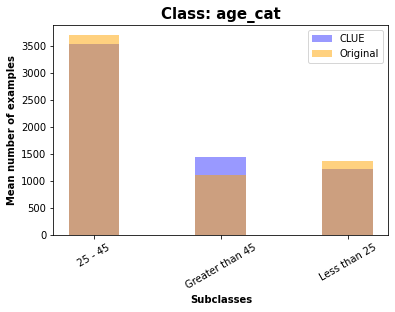

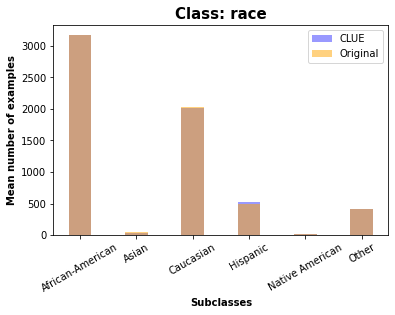

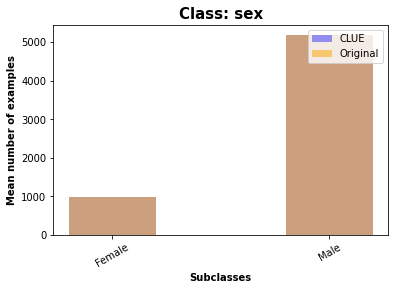

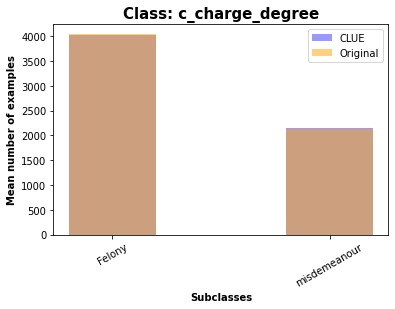

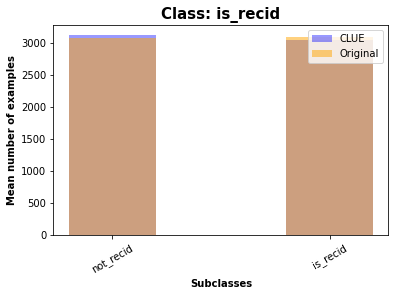

priors_count
mean tensorflow:  -0.04487705071992241
std tensorflow:  0.01588583766059863
mean torch:  -0.0851037929
mean torch:  0.0154537846
time_served
mean tensorflow:  -0.11462630613893271
std tensorflow:  0.015349036755940198
mean torch:  -0.0621463754
mean torch:  0.0150264269


NameError: name 'num_features_y_' is not defined

In [17]:
# For COMPAS
"""
regression_bools = False
gauss_cat_vae_bools = True
flat_vae_bools = False
flat_vaeac_bools = False
"""

num_runs = 1000

num_features_x = np.zeros((num_runs, sum(input_dim_vec)))
num_features_xy = np.zeros((num_runs, sum(input_dim_vec_xy)))
num_features_y = np.zeros((num_runs, sum(input_dim_vec_xy) - sum(input_dim_vec)))

for run in range(num_runs):
    Npoints = art_Npoints[d_idx] # Number of total data points (features + targets) (6172 for COMPAS)
    Ntrain = art_Ntrain[d_idx] # Number of features (5554 for compas)


    # test_dims[d_idx] = [17, 18]
    # u_dims = vaeac_under_latent_dims[d_idx] = 4
    # sig = ((not gauss_cat_vae_bools[d_idx]) and regression_bools[d_idx]) = False
    # softmax = False

    #print("input_dim_vec: ", input_dim_vec)
    #print("input_dim_vec_xy: ", input_dim_vec_xy)

    x_art, y_art, xy_art = sample_artificial_dataset(under_VAEAC_net, test_dims[d_idx], Npoints,
                                    u_dims=vaeac_under_latent_dims[d_idx],
                                                     sig=((not gauss_cat_vae_bools[d_idx]) and regression_bools[d_idx]),
                                                     softmax=False)

    # COMPAS does this
    if gauss_cat_vae_bools[d_idx]:

        x_art = selective_softmax(x_art, input_dim_vec, num_features_x, run, grad=False, cat_probs=True, prob_sample=True) # makes output probabilistic and draws sample
        #print("========================")
        xy_art = selective_softmax(xy_art, input_dim_vec_xy, num_features_xy, run, grad=False, cat_probs=True, prob_sample=True)
        #print("========================")
    y_art_gen = y_art

    conditional_targets = False 

    # COMPAS does this
    if not regression_bools[d_idx]:

        # COMPAS does not go in here (TODO check what conditional targets does)
        if conditional_targets:
            y_art = sample_artificial_targets_cat(VAEAC, xy_art, test_dims[d_idx], N_target_samples=500,
                                                  z_mean=False, softmax=False).data
            y_art = y_art.mean(dim=0)

        else:
            y_art = selective_softmax(y_art, [2], num_features_y, run, grad=False, cat_probs=True, prob_sample=True)

        #print(y_art.shape)
        #print("y_art ", y_art)
        #_, y_art_BNN = y_art.max(dim=1)  # get integer label
        y_art_BNN = tf.math.argmax(y_art, axis=1)
        #print(" y art BNN ", y_art_BNN)

    # COMPAS does not do this
    else:
        if conditional_targets:
            y_art, stds = sample_artificial_targets_gauss(VAEAC, xy_art, test_dims[d_idx], N_target_samples=500,
                                            pred_sig=((not gauss_cat_vae_bools[d_idx]) and regression_bools[d_idx]),
                                            z_mean=False)
            y_art = y_art.mean(dim=0)

        y_art_BNN = y_art
        if len(y_art_BNN.shape) == 1:
            y_art_BNN = y_art_BNN.unsqueeze(1)


    ###################################################################################################

    # xy_art_train = xy_art[:Ntrain, :].cpu().numpy()
    # xy_art_test = xy_art[Ntrain:, :].cpu().numpy()

    x_art_train = x_art[:Ntrain, :].numpy()
    x_art_test = x_art[Ntrain:, :].numpy()

    y_art_train = y_art[:Ntrain, :].numpy()
    y_art_test = y_art[Ntrain:, :].numpy()

    # COMPAS does not do this
    if regression_bools[d_idx]:
        y_art_BNN_train = y_art_BNN[:Ntrain, :].numpy()
        y_art_BNN_test = y_art_BNN[Ntrain:, :].numpy()

    # COMPAS does this
    else:
        y_art_BNN_train = y_art_BNN[:Ntrain].numpy()
        y_art_BNN_test = y_art_BNN[Ntrain:].numpy()

    #print('------------')
    #print(x_art_train.shape)
    #print(y_art_train.shape)
    #print(x_art_test.shape)
    #print(y_art_test.shape)


"""
print("==========")
print(np.mean(num_features_x, axis = 0))
print(np.std(num_features_x, axis = 0))
print("==========")
print(np.mean(num_features_xy, axis = 0))
print(np.std(num_features_xy, axis = 0))
print("==========")
"""
print(np.mean(num_features_y, axis = 0))
print(np.std(num_features_y, axis = 0))

#langs = ['C', 'C++', 'Java', 'Python', 'PHP']
#students = [23,17,35,29,12]
#plt.bar(langs, students, color ='maroon', width = 0.4)
#plt.show()

#"""

var_names['compas'] = ["age_cat", "race", "sex", "c_charge_degree", 'is_recid', 'priors_count', 'time_served']
var_names_flat['compas'] = ['25 - 45', 'Greater than 45', 'Less than 25', 'African-American', 'Asian', \
                            'Caucasian', 'Hispanic', 'Native American', 'Other', 'Female', 'Male', 'Felony', \
                            'misdemeanour', 'not_recid', 'is_recid', 'priors_count', 'time_served']

torch_num_features_x_mean =  np.array([3.69275900e+03,  1.10965400e+03,  1.36958700e+03,  3.16888700e+03,
  4.82240000e+01,  2.03755900e+03,  4.93308000e+02,  1.52050000e+01,
  4.08817000e+02,  9.92142000e+02,  5.17985800e+03,  4.03655900e+03,
  2.13544100e+03,  3.08148700e+03,  3.09051300e+03, -8.51037929e-02,
 -6.21463754e-02])

torch_num_features_x_std = np.array([3.79459473e+01, 2.99582423e+01, 3.31079814e+01, 4.02633112e+01,
 6.77346470e+00, 3.74792012e+01, 2.15417997e+01, 3.86768342e+00,
 1.87830645e+01, 2.83613440e+01, 2.83613440e+01, 3.51720133e+01,
 3.51720133e+01, 3.92112972e+01, 3.92112972e+01, 1.54537846e-02,
 1.50264269e-02])
"""
torch_num_features_xy_mean = np.array([ 3.69050000e+03,  1.11870000e+03,  1.36280000e+03,  3.15980000e+03,
  4.76000000e+01,  2.03970000e+03,  4.95400000e+02,  1.58000000e+01,
  4.13700000e+02,  9.93700000e+02,  5.17830000e+03,  4.03700000e+03,
  2.13500000e+03,  3.09040000e+03,  3.08160000e+03, -8.03368729e-02,
 -6.56578202e-02,  3.46630000e+03,  2.70570000e+03])

torch_num_features_xy_std = np.array([2.96352830e+01, 3.39766096e+01, 2.83964787e+01, 4.19161067e+01,
 5.48087584e+00, 4.35041377e+01, 2.44221211e+01, 2.56124969e+00,
 1.76354756e+01, 3.87557738e+01, 3.87557738e+01, 2.80035712e+01,
 2.80035712e+01, 4.22946805e+01, 4.22946805e+01, 1.69547189e-02,
 9.57655964e-03, 4.49089078e+01, 4.49089078e+01])
"""
torch_num_features_y_mean = np.array([3467.2, 2704.8])
torch_num_features_y_std = np.array([44.52370155, 44.52370155])

num_features_x_mean = np.mean(num_features_x, axis = 0)
num_features_x_std = np.std(num_features_x, axis = 0)

num_features_xy_mean = np.mean(num_features_xy, axis = 0)
num_features_xy_std = np.std(num_features_xy, axis = 0)

num_features_y_mean = np.mean(num_features_y, axis = 0)
num_features_y_std = np.std(num_features_y, axis = 0)

bar_width = 0.4
cum_dims = 0
print("dim_vec xy: ", input_dim_vec)
for idx, dim in enumerate(input_dim_vec):
    
    if dim == 1:
        print(var_names_flat['compas'][cum_dims])
        print("mean tensorflow: ", num_features_x_mean[cum_dims])
        print("std tensorflow: ", num_features_x_std[cum_dims])
        print("mean torch: ", torch_num_features_x_mean[cum_dims])
        print("mean torch: ", torch_num_features_x_std[cum_dims])
        print("============================")
        cum_dims += dim
    else:
        class_list = range(dim)
        x = np.mean(num_features_x, axis = 0)[cum_dims:cum_dims+dim]
        plt.subplots_adjust(bottom=0.15)
        plt.bar(class_list, x, color ='blue', width = bar_width, alpha=0.4, label="CLUE")
        
        # Adding Xticks
        plt.title("Class: " + var_names['compas'][idx], fontweight ='bold', fontsize = 15)
        plt.xlabel('Subclasses', fontweight ='bold', fontsize = 10)
        plt.ylabel('Mean number of examples', fontweight ='bold', fontsize = 10)
        plt.xticks([r for r in range(dim)], [var_name for var_name in var_names_flat['compas'][cum_dims:cum_dims+dim]], rotation = 30)

        
        plt.bar(class_list, torch_num_features_x_mean[cum_dims:cum_dims+dim], color ='orange', width = bar_width, alpha=0.5, label="Original")
        
        cum_dims += dim
        
        plt.legend(loc="upper right")
        plt.savefig('./figures/' + var_names['compas'][idx] + '.png', bbox_inches="tight")
        plt.show()






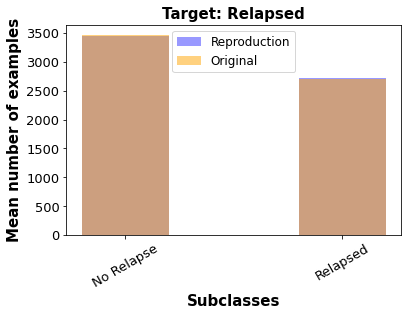

In [53]:
class_list = range(2)
x = np.mean(num_features_y, axis = 0)
plt.subplots_adjust(bottom=0.15)
plt.bar(class_list, x, color ='blue', width = bar_width, alpha=0.4, label="Reproduction")

# Adding Xticks
plt.title("Target: Relapsed", fontweight ='bold', fontsize = 15)
plt.xlabel('Subclasses', fontweight ='bold', fontsize = 15)
plt.ylabel('Mean number of examples', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(2)], ['No Relapse', 'Relapsed'], rotation = 30, fontsize = 13)
plt.yticks(fontsize = 13)


plt.bar(class_list, torch_num_features_y_mean, color ='orange', width = bar_width, alpha=0.5, label="Original")

plt.legend(loc='upper center', fontsize=12)
plt.savefig('./figures/targets.png', bbox_inches="tight")
plt.show()

dim_vec xy:  [3 6 2 2 2 1 1]


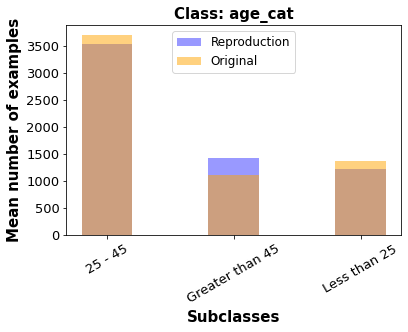

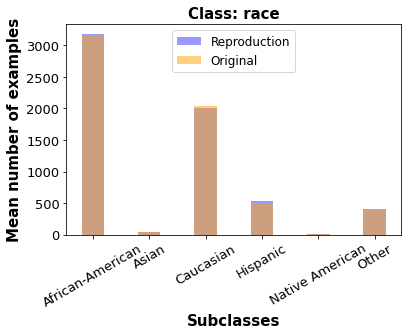

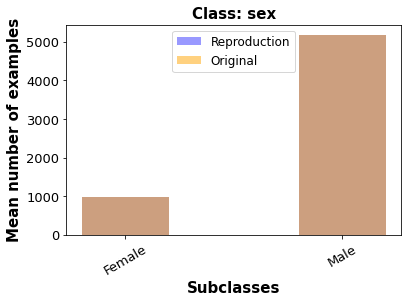

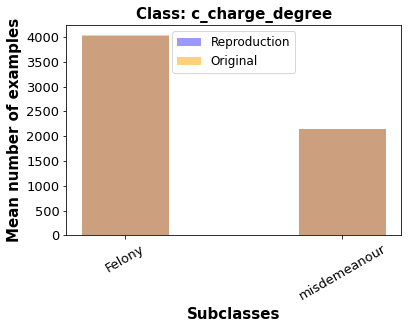

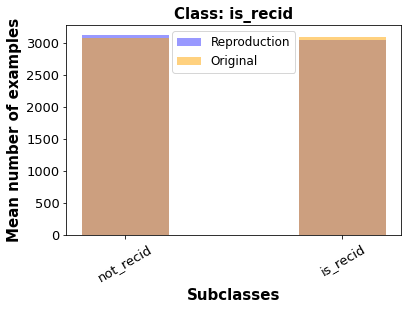

priors_count
mean tensorflow:  -0.04487705071992241
std tensorflow:  0.01588583766059863
mean torch:  -0.0851037929
mean torch:  0.0154537846
time_served
mean tensorflow:  -0.11462630613893271
std tensorflow:  0.015349036755940198
mean torch:  -0.0621463754
mean torch:  0.0150264269


In [54]:
bar_width = 0.4
cum_dims = 0
print("dim_vec xy: ", input_dim_vec)
for idx, dim in enumerate(input_dim_vec):
    
    if dim == 1:
        print(var_names_flat['compas'][cum_dims])
        print("mean tensorflow: ", num_features_x_mean[cum_dims])
        print("std tensorflow: ", num_features_x_std[cum_dims])
        print("mean torch: ", torch_num_features_x_mean[cum_dims])
        print("mean torch: ", torch_num_features_x_std[cum_dims])
        print("============================")
        cum_dims += dim
    else:
        class_list = range(dim)
        x = np.mean(num_features_x, axis = 0)[cum_dims:cum_dims+dim]
        plt.subplots_adjust(bottom=0.15)
        plt.bar(class_list, x, color ='blue', width = bar_width, alpha=0.4, label="Reproduction")
        
        # Adding Xticks
        plt.title("Class: " + var_names['compas'][idx], fontweight ='bold', fontsize = 15)
        plt.xlabel('Subclasses', fontweight ='bold', fontsize = 15)
        plt.ylabel('Mean number of examples', fontweight ='bold', fontsize = 15)
        plt.xticks([r for r in range(dim)], [var_name for var_name in var_names_flat['compas'][cum_dims:cum_dims+dim]], rotation = 30, fontsize = 13)
        plt.yticks(fontsize = 13)
        
        plt.bar(class_list, torch_num_features_x_mean[cum_dims:cum_dims+dim], color ='orange', width = bar_width, alpha=0.5, label="Original")
        
        cum_dims += dim
        
        plt.legend(loc="upper center", fontsize=12)
        plt.savefig('./figures/' + var_names['compas'][idx] + '.png', bbox_inches="tight")
        plt.show()

In [ ]:

# Old torch data
torch_num_features_x_mean =  np.array([ 3.68950000e+03,  1.12300000e+03,  1.35950000e+03,  3.16970000e+03,
                                        4.17000000e+01,  2.04150000e+03,  4.92100000e+02,  1.71000000e+01,
                                        4.09900000e+02,  9.97200000e+02,  5.17480000e+03,  4.03240000e+03,
                                        2.13960000e+03,  3.09230000e+03,  3.07970000e+03, -7.84561124e-02,
                                       -6.29379440e-02])

torch_num_features_x_std = np.array([1.98053023e+01, 2.58573007e+01, 2.95203320e+01, 4.31510139e+01,
                                     5.81463670e+00, 4.24293530e+01, 2.10734430e+01, 5.28109837e+00,
                                     7.23118248e+00, 3.16600695e+01, 3.16600695e+01, 3.49519670e+01,
                                     3.49519670e+01, 4.40591648e+01, 4.40591648e+01, 1.02158272e-02,
                                     1.73252516e-02])

In [50]:

# Torch 1000 runs
# Data from torch runs 
"""
torch_num_features_x_mean =  np.array([3.69275900e+03,  1.10965400e+03,  1.36958700e+03,  3.16888700e+03,
  4.82240000e+01,  2.03755900e+03,  4.93308000e+02,  1.52050000e+01,
  4.08817000e+02,  9.92142000e+02,  5.17985800e+03,  4.03655900e+03,
  2.13544100e+03,  3.08148700e+03,  3.09051300e+03, -8.51037929e-02,
 -6.21463754e-02])

torch_num_features_x_std = np.array([3.79459473e+01, 2.99582423e+01, 3.31079814e+01, 4.02633112e+01,
 6.77346470e+00, 3.74792012e+01, 2.15417997e+01, 3.86768342e+00,
 1.87830645e+01, 2.83613440e+01, 2.83613440e+01, 3.51720133e+01,
 3.51720133e+01, 3.92112972e+01, 3.92112972e+01, 1.54537846e-02,
 1.50264269e-02])
"""
torch_num_features_xy_mean = np.array([3.69234100e+03,  1.10972900e+03,  1.36993000e+03,  3.17006300e+03,
  4.82430000e+01,  2.03786500e+03,  4.91491000e+02,  1.51760000e+01,
  4.09162000e+02,  9.92686000e+02,  5.17931400e+03,  4.03761500e+03,
  2.13438500e+03,  3.08183000e+03,  3.09017000e+03, -8.54127773e-02,
 -6.11552128e-02, 3.45235100e+03,  2.71964900e+03])

torch_num_features_xy_std = np.array([3.77735188e+01, 2.97694736e+01, 3.26516937e+01, 4.02207289e+01,
 7.00513747e+00, 3.75004103e+01, 2.15250997e+01, 3.93408490e+00,
 1.90842803e+01, 2.79218088e+01, 2.79218088e+01, 3.45559948e+01,
 3.45559948e+01, 3.91356500e+01, 3.91356500e+01, 1.59745012e-02,
 1.48372692e-02, 3.86857312e+01, 3.86857312e+01])

torch_mean = ''
torch_std = ''
for i in range(19):
    if not ((i==15) or (i==16)):
        torch_mean = torch_mean + ' & ' + str(round(torch_num_features_xy_mean[i], 2)) 
        torch_std = torch_std +  ' & ' + str(round(torch_num_features_xy_std[i], 2))
    else:
        torch_mean = torch_mean + ' & ' + str(round(torch_num_features_xy_mean[i], 4))
        torch_std = torch_std +  ' & ' + str(round(torch_num_features_xy_std[i], 4))


tf_mean = ''
tf_std = ''
for i in range(19):
    if not ((i==15) or (i==16)):
        tf_mean = tf_mean + ' & ' + str(round(num_features_xy_mean[i], 2)) 
        tf_std = tf_std +  ' & ' + str(round(num_features_xy_std[i], 2))
    else:
        tf_mean = tf_mean + ' & ' + str(round(num_features_xy_mean[i], 4))
        tf_std = tf_std +  ' & ' + str(round(num_features_xy_std[i], 4))

        
print("Tensorflow mean")
print(tf_mean)
print("Torch mean ")
print(torch_mean)

print("Tensorflow std")
print(tf_std)
print("Torch std ")
print(torch_std)




#torch_num_features_y_mean = np.array([3452.574 2719.426])
#torch_num_features_y_std = np.array([38.18861773 38.18861773])



Tensorflow mean
 & 3520.5 & 1435.08 & 1216.42 & 3172.91 & 38.28 & 2009.6 & 529.8 & 13.12 & 408.28 & 989.49 & 5182.51 & 4022.67 & 2149.33 & 3121.39 & 3050.61 & -0.0449 & -0.1151 & 3446.03 & 2725.97
Torch mean 
 & 3692.34 & 1109.73 & 1369.93 & 3170.06 & 48.24 & 2037.86 & 491.49 & 15.18 & 409.16 & 992.69 & 5179.31 & 4037.62 & 2134.39 & 3081.83 & 3090.17 & -0.0854 & -0.0612 & 3452.35 & 2719.65
Tensorflow std
 & 38.63 & 33.28 & 31.08 & 40.21 & 5.97 & 38.04 & 22.71 & 3.45 & 19.28 & 28.72 & 28.72 & 37.22 & 37.22 & 39.12 & 39.12 & 0.0155 & 0.0147 & 38.9 & 38.9
Torch std 
 & 37.77 & 29.77 & 32.65 & 40.22 & 7.01 & 37.5 & 21.53 & 3.93 & 19.08 & 27.92 & 27.92 & 34.56 & 34.56 & 39.14 & 39.14 & 0.016 & 0.0148 & 38.69 & 38.69


In [30]:
class top_masker_tensorflow:
    """
    Returned mask is sampled from component-wise independent Bernoulli
    distribution with probability of component to be unobserved p.
    Such mask induces the type of missingness which is called
    in literature "missing completely at random" (MCAR).
    If some value in batch is missed, it automatically becomes unobserved.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        """
        Parameters:
            - batch is a numpy array with as many rows as batch_size and as many columns as features
        
        Returned:
       
            - mask is a float32 tensor
        
        The mask seems to be random
        """
        # Generate one uniform number for each row (1xrow numpy matrix)
        pp = uniform(low=0.0, high=self.p, size=batch.shape[0]) 
        pp = np.expand_dims(pp, axis=1) # Put the number in 1x1 matrices in a 1x#row matrix
        pp = np.repeat(pp, batch.shape[1], axis=1) # Repeat the number across each row
        nan_mask = tf.math.is_nan(batch) # If nan => should be unobserved i.e. boolean True
        
        # Generate Bernoulli samples (0 or 1) from pp i.e. for each sample in batch determine if a feature is
        # observed or hidden.
        bernoulli_mask_numpy = binomial(1, pp, size=None) 
        bernoulli_mask = tf.convert_to_tensor(tf.cast(bernoulli_mask_numpy, tf.bool))
        mask = tf.math.logical_or(bernoulli_mask, nan_mask) # Logical or between bernoulli and nan mask
        
        # Logical not to invert the mask (This is done in CLUE)
        # Mask is converted to a boolean tensor with floats for element wise multiplication with the batch
        # which is done in apply mask
        # (True => 0, False => 1)
        
        # TODO: The logical_not might be unnecessary as the probability of getting a true or false is equal.
        #      To mirror the Torch code however I did this but it can perhaps be removed later...
        
        return tf.cast(tf.math.logical_not(mask), dtype=tf.float32)
        #return tf.cast(mask, dtype=tf.float32)

In [23]:
masker = top_masker_tensorflow(p=1)

#x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
#    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

#x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

#print('Compas', x_train.shape, x_test.shape)
#print(input_dim_vec)

dname = 'compas'
print(dname)

width = vaeac_widths[d_idx]
depth = vaeac_depths[d_idx] # number of hidden layers
latent_dim = vaeac_latent_dims[d_idx]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = False)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_art_train, x_art_test, masker, nb_epochs, early_stop=early_stop, flatten = False)



compas


KeyboardInterrupt: 

In [131]:
### CURRENTLY WORKING ON ###

# Get the TORCH generate artificial dataset to work

# What is the point of conditional targets?

### TODO ###

# Evaluation with tensorflow

# Get selective softmax to work in tensorflow

# Get sample_artificial_dataset to work in TF

# Get sample_artificial_targets_cat to work in TF

### DONE ###
"""
√ Load the VAEAC and under_VAEAC

√ u_generate (for categorical and continous data (Not for only continous i.e. wine))


"""

'\n√ Load the VAEAC and under_VAEAC\n\n√ u_generate (for categorical and continous data (Not for only continous i.e. wine))\n\n\n'